In [1]:
import requests 
import pandas as pd
import re
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np

Получим датасет

In [158]:
df = pd.read_csv("df_judges_dump.csv")

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23852 entries, 0 to 23851
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   23852 non-null  int64 
 1   title        23852 non-null  object
 2   date         23852 non-null  object
 3   place        23852 non-null  object
 4   online_link  23852 non-null  object
 5   category     23852 non-null  object
 6   segment      23852 non-null  object
 7   position     23852 non-null  object
 8   name         23757 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


In [160]:
# Удалим строки без судей
df = df.dropna()

In [161]:
df[df[['date', 'name']].duplicated()]

,Unnamed: 0,title,date,place,online_link,category,segment,position,name
6,6,Межмуниципальные соревнования Московской облас...,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/SEG...,"3 юнoшеский разряд, дeвочки",Произвольная программа,Referee,Павел ТАТАРЕНКО
7,7,Межмуниципальные соревнования Московской облас...,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/SEG...,"3 юнoшеский разряд, дeвочки",Произвольная программа,Technical Controller,Ольга КОВАЛЬ
8,8,Межмуниципальные соревнования Московской облас...,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/SEG...,"3 юнoшеский разряд, дeвочки",Произвольная программа,Technical Specialist,Михаил КАЗАКОВ
9,9,Межмуниципальные соревнования Московской облас...,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/SEG...,"3 юнoшеский разряд, дeвочки",Произвольная программа,Judge No.1,Павел ТАТАРЕНКО
10,10,Межмуниципальные соревнования Московской облас...,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/SEG...,"3 юнoшеский разряд, дeвочки",Произвольная программа,Judge No.2,Юлия СОЛОМИНА
...,...,...,...,...,...,...,...,...,...
23847,44,Спортивные соревнования Московской области по ...,16.04.2025,"г. Селятино, Спорткомбинат ""Строитель"" Ледовая...",http://ffkkmo.ru/events/2425/sel04/SEG007OF.HTM,"3 cпoртивный рaзряд, юнoши",Произвольная программа,Технический специалист,Алксандр КОНДАКОВ
23848,45,Спортивные соревнования Московской области по ...,16.04.2025,"г. Селятино, Спорткомбинат ""Строитель"" Ледовая...",http://ffkkmo.ru/events/2425/sel04/SEG007OF.HTM,"3 cпoртивный рaзряд, юнoши",Произвольная программа,Судья No.1,Светлана СОЛОМИНА
23849,46,Спортивные соревнования Московской области по ...,16.04.2025,"г. Селятино, Спорткомбинат ""Строитель"" Ледовая...",http://ffkkmo.ru/events/2425/sel04/SEG007OF.HTM,"3 cпoртивный рaзряд, юнoши",Произвольная программа,Судья No.2,Анастасия ГОРЯЧЕВА
23850,47,Спортивные соревнования Московской области по ...,16.04.2025,"г. Селятино, Спорткомбинат ""Строитель"" Ледовая...",http://ffkkmo.ru/events/2425/sel04/SEG007OF.HTM,"3 cпoртивный рaзряд, юнoши",Произвольная программа,Судья No.3,Елена БОЛДЕНКО


In [162]:
# Приведем типы данных
df['date'] = df['date'].str.strip()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [163]:
# Добавим год
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['season'] = df['date'].apply(lambda x: f"{x.year-2001}{x.year-2000}" if x.month < 8 else f"{x.year-2000}{x.year-1999}")

In [164]:
def replace_duplicates(df, keyword, name, field='position'):
    uniquenames = [ s for s in df[field].unique() if keyword.findall(str(s).lower()) ]
    return df[field].replace(uniquenames, name)

In [165]:
def get_regex(str_val):
    return re.compile((r"(" + str_val + ")").lower())

In [166]:
df.name = df.name.str.strip()
df.name = df.name.str.replace("ё", "е")
df.name = df.name.str.replace("Ё", "Е")
df.name = df.name.str.replace("  ", " ")

In [183]:
[ s for s in df.name.unique() if get_regex('ей РОГ').findall(str(s).lower()) ]

['Алексей РОГОЗИНСКИЙ']

In [182]:
df.position = replace_duplicates(df, get_regex('специалист'), 'Технический специалист')
df.position = replace_duplicates(df, get_regex('Specialist'), 'Технический специалист')
df.position = replace_duplicates(df, get_regex('контролер'), 'Технический контролер')
df.position = replace_duplicates(df, get_regex('Controller'), 'Технический контролер')
df.position = replace_duplicates(df, get_regex('Replay'), 'Оператор видеоповтора')
df.position = replace_duplicates(df, get_regex('Data'), 'Оператор ввода данных')
df.position = replace_duplicates(df, get_regex('Referee'), 'Рефери')
df.position = replace_duplicates(df, get_regex('1'), 'Судья')
df.position = replace_duplicates(df, get_regex('2'), 'Судья')
df.position = replace_duplicates(df, get_regex('3'), 'Судья')
df.position = replace_duplicates(df, get_regex('4'), 'Судья')
df.position = replace_duplicates(df, get_regex('5'), 'Судья')
df.position = replace_duplicates(df, get_regex('6'), 'Судья')
df.position = replace_duplicates(df, get_regex('7'), 'Судья')
df.name = replace_duplicates(df, get_regex('шуркалова'), 'Елизавета ВЛАСЕНКО', field='name')
df.name = replace_duplicates(df, get_regex('ей РОГ'), 'Алексей РОГОЗИНСКИЙ', field='name')
df.position.unique()

array(['Рефери', 'Технический контролер', 'Технический специалист',
       'Судья', 'Оператор видеоповтора', 'Оператор ввода данных'],
      dtype=object)

In [201]:
df[(df['name'] == 'Анастасия АГИБАЛОВА')]

,Unnamed: 0,title,date,place,online_link,category,segment,position,name,year,month,season
6076,4,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"3 спортивный разряд, девушки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6083,11,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"1 юношеский разряд, девочки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6090,18,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"1 юношеский разряд, мальчики",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6097,25,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"2 юношеский разряд, девочки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6104,32,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"2 юношеский разряд, мальчики",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6111,39,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"3 юношеский разряд, девочки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6118,46,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"3 юношеский разряд, мальчики",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
6125,53,Соревнования Московской области по фигурному к...,2022-01-26,"г. Ногинск, ул. Климова д. 48 а, Ледовая арена...",http://ffkkmo.ru/events/2122/noginsk0126/SEG00...,"Юный фигурист, девочки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2022,1,2122
20789,6,Спортивные соревнования Московской области по ...,2024-10-26,"г. Наро-Фоминск, ул. Профсоюзная, д. 36Б, ледо...",http://ffkkmo.ru/events/2425/nf10/SEG001OF.HTM,"Hoрмa Юный фигуриcт, дeвoчки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2024,10,2425
20797,14,Спортивные соревнования Московской области по ...,2024-10-26,"г. Наро-Фоминск, ул. Профсоюзная, д. 36Б, ледо...",http://ffkkmo.ru/events/2425/nf10/SEG002OF.HTM,"3 юнoшecкий рaзряд, дeвoчки",Произвольная программа,Судья,Анастасия АГИБАЛОВА,2024,10,2425


In [199]:
temp_df = df[df.season == '2425'].drop_duplicates(['date', 'name', 'position']).groupby(['position', 'name']).count()['title']
temp_df

position                name               
Оператор ввода данных   Алексей ПОЛЕТОВ         1
                        Алексей РОГОЗИНСКИЙ    25
                        Владислав ГРИЦАЙ        1
                        Михаил КАЗАКОВ          1
Рефери                  Анастасия АГИБАЛОВА     1
                                               ..
Технический специалист  Мария СЕМЕНОВА          2
                        Михаил КАЗАКОВ          5
                        Наталия ЛЕБЕДЕВА        1
                        Оксана АНДРИЕНКО        2
                        Станислав КОВАЛЕВ      10
Name: title, Length: 92, dtype: int64

In [172]:
temp_df.loc['Технический специалист'].sort_values(ascending=False)

name
Евгений ПРОКОФЬЕВ           65
Михаил КАЗАКОВ              56
Станислав КОВАЛЕВ           33
Александр САМОХВАЛОВ        21
Наталия ЛЕБЕДЕВА            15
Светлана БИЯН               14
Александр КОНДАКОВ          13
Екатерина МОНИЧ             10
Оксана АНДРИЕНКО             8
Артем НОВИКОВ                5
Елизавета РАЧЕВА             3
Андрей ДЕНИСОВ               3
Алексей ГУБАНОВ              3
Наталья ЛЕБЕДЕВА             2
Мария СЕМЕНОВА               2
Лариса МЕЛКОВА               2
Никита ТРУШКОВ               2
Юлия МАРТЮШЕВА               2
Андрей ЛЕБЕДЬ                2
Mr. Станислав КОВАЛЕВ        1
Ирина СМИРНОВА               1
Георгий КОЗАЧИНСКИЙ          1
Владислав МИРЗОЕВ            1
Андрей Лебедь                1
Анастасия ШИПОВА             1
Анастасия ИЛЬЯНОВА           1
Алксандр КОНДАКОВ            1
Олеся ПОЛЗУНОВА              1
Павел САМОХИН                1
Александра АВСТРИЙСКАЯ       1
Солтан КОКОЕВ                1
Александр КУЗНЕЦОВ           1
Ста

In [173]:
temp_df.loc['Технический контролер'].sort_values(ascending=False)

name
Ольга КОВАЛЬ                     53
Елена МЕЛИКОВА                   33
Юлия СОЛОМИНА                    26
Павел ТАТАРЕНКО                  25
Елизавета ВЛАСЕНКО               18
Елена НОВИКОВА                   18
Антон ШАРОВ                      14
Татьяна ФЕДОРОВА                 14
Полина МАЗОРЧУК                  10
Дарья ФИЛЯКИНА                    9
Антон СОЛОВЬЕВ                    7
Полина ГЛУШАК                     5
Елизавета КИРИЛЛОВА               4
Елена ЭЙСМОНТ                     3
Дарья БАРАНОВА                    3
Константин ЯБЛОЦКИЙ               3
Анастасия КАЙГОРОДОВА             3
Алексей УСАНОВ                    2
Полина МОЗАРЧУК                   2
Юлия ИЛИЕВА                       2
Сергей ЧЕМОДАНОВ                  2
Татьяна ПОЛЯКОВА (ПОНОМАРЕВА)     1
Ms. Елена МЕЛИКОВА                1
Ольга ШЕВЦОВА                     1
Наталья ПАВЛОВА                   1
Елизавета Кириллова               1
Елена БЛАГОДЕРОВА                 1
Екатерина ФАГУРЕЛ      

In [174]:
temp_df.loc['Оператор ввода данных'].sort_values(ascending=False)

name
Алексей РОГОЗИНСКИЙ        73
Алексей ПОЛЕТОВ            28
Кира ТАТАРЕНКО              9
Евгения СУББОТИНА           4
Евгений ПРОКОФЬЕВ           2
Mr. Алексей РОГОЗИНСКИЙ     1
Алексей РОГОЗОНСКИЙ         1
Алескей РОГОЗИНСКИЙ         1
Аллексей РОГОЗИНСКИЙ        1
Владислав ГРИЦАЙ            1
Михаил КАЗАКОВ              1
Name: title, dtype: int64

In [175]:
temp_df.loc['Рефери'].sort_values(ascending=False)

name
Елена КАЛИНКИНА          49
Елизавета ВЛАСЕНКО       44
Евгения СУББОТИНА        25
Елена МЕЛИКОВА           20
Павел ТАТАРЕНКО          17
Анастасия ШЕРЕМЕТЬЕВА    16
Юлия СОЛОМИНА            15
Татьяна СОЛОВЫХ          11
Светлана СОЛОМИНА         9
Дарья ФИЛЯКИНА            9
Сергей ЧЕМОДАНОВ          7
Ольга КОВАЛЬ              6
Наталья СОЛОВЬЕВА         6
Лилия РОЖКОВА             4
Елена НОВИКОВА            4
Татьяна ФЕДОРОВА          3
Дарья БАРАНОВА            3
Яна СУСЛЕНКО              3
Ирина ГАЛКИНА             2
Дарья НУЖДИНА             2
Анастасия СВИРИДОВА       2
Татьяна ДАНИЛЕНКО         1
Светлана ЧИКАЛОВА         1
Ms. Наталья СОЛОВЬЕВА     1
Светлана СТРОИЛОВА        1
Наталья КИТАЕВА           1
Анастасия АГИБАЛОВА       1
Елизавета КИРИЛЛОВА       1
Дарья Филякина            1
Константин ЯБЛОЦКИЙ       1
Name: title, dtype: int64

In [177]:
temp_df.loc['Судья'].sort_values(ascending=False).head(20)

name
Елена КАЛИНКИНА          92
Юлия СОЛОМИНА            69
Елизавета ВЛАСЕНКО       69
Светлана СОЛОМИНА        49
Людмила ПРОКОФЬЕВА       48
Евгения СУББОТИНА        46
Валентина ВОЛКОВА        46
Павел ТАТАРЕНКО          35
Дарья НУЖДИНА            35
Полина МАЗОРЧУК          33
Татьяна ПОНОМАРЕВА       30
Дарья ФИЛЯКИНА           27
Елена МЕЛИКОВА           25
Александра АСТАФЬЕВА     23
Елена БОЛДЕНКО           23
Татьяна СОЛОВЫХ          22
Анастасия ШЕРЕМЕТЬЕВА    21
Алена КРАСНОВА           19
Елена НОВИКОВА           19
Екатерина РОМАДАНОВА     19
Name: title, dtype: int64

In [98]:
def judge_in_seasons(df, name):
    data = df[df.name == name].groupby(['season']).count()['title']
    ax = data.plot(
        kind='bar', figsize=(20, 5), grid=True
    )
    major_ticks = np.arange(0, max(data) + 1, 1)
    ax.set_yticks(major_ticks)
    plt.title(name, fontsize=32)
    plt.xlabel('Сезон', fontsize=16)
    plt.ylabel(f'Количество участий', fontsize=18)
    plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [191]:
def judges_in_season(df, season=None, limit=100, plot=True, sort_col='title'):
    if season is None:
        data = df
    else:
        data = df[df['season'] == season]
    data = data.groupby(['name']).count().sort_values(
        by=sort_col, ascending=False).head(limit)['title']
    if plot:
        ax = data.plot(
            kind='bar', figsize=(20, 5), grid=True
        )
        major_ticks = np.arange(0, max(data) + 1, 1)
        if season is not None:
            ax.set_yticks(major_ticks)
            plt.title("Сезон " + season, fontsize=32)
        plt.xlabel('Судья', fontsize=16)
        plt.ylabel(f'Количество участий', fontsize=18)
        plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');
    else:
        return data

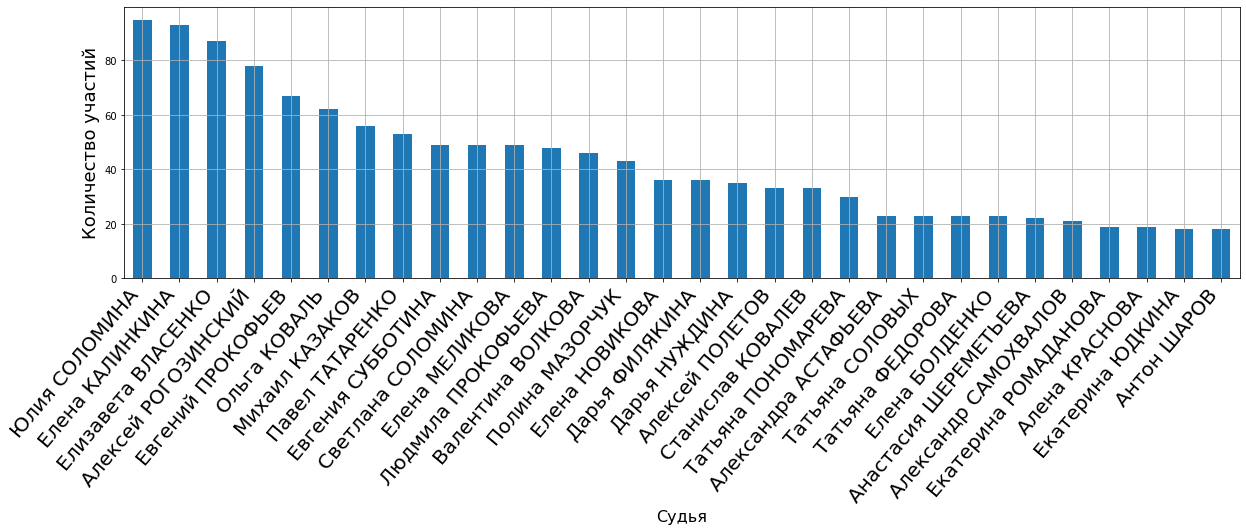

In [194]:
judges_in_season(df.drop_duplicates(['date', 'name']), limit=30)

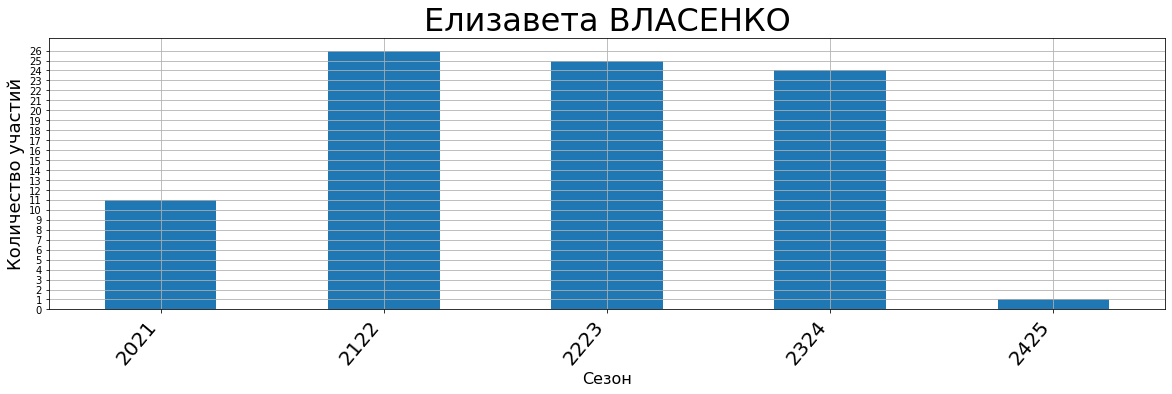

In [196]:
judge_in_seasons(df.drop_duplicates(['date', 'name']), 'Елизавета ВЛАСЕНКО')

In [197]:
df[df.name == 'Елизавета ВЛАСЕНКО']

,Unnamed: 0,title,date,place,online_link,category,segment,position,name,year,month,season
54,6,Соревнования Московской области по фигурному к...,2020-10-17,"г. Красногорск, ул. Лесная, д. 1А, ЛД им. В. П...",http://ffkkmo.ru/events/2021/krasnogorsk1718/S...,"1 cпoртивный рaзряд, дeвушки",Короткая программа,Судья,Елизавета ВЛАСЕНКО,2020,10,2021
61,13,Соревнования Московской области по фигурному к...,2020-10-17,"г. Красногорск, ул. Лесная, д. 1А, ЛД им. В. П...",http://ffkkmo.ru/events/2021/krasnogorsk1718/S...,"1 cпoртивный рaзряд, дeвушки",Произвольная программа,Судья,Елизавета ВЛАСЕНКО,2020,10,2021
68,20,Соревнования Московской области по фигурному к...,2020-10-17,"г. Красногорск, ул. Лесная, д. 1А, ЛД им. В. П...",http://ffkkmo.ru/events/2021/krasnogorsk1718/S...,"1 cпoртивный рaзряд, юнoши",Короткая программа,Судья,Елизавета ВЛАСЕНКО,2020,10,2021
75,27,Соревнования Московской области по фигурному к...,2020-10-17,"г. Красногорск, ул. Лесная, д. 1А, ЛД им. В. П...",http://ffkkmo.ru/events/2021/krasnogorsk1718/S...,"1 cпoртивный рaзряд, юнoши",Произвольная программа,Судья,Елизавета ВЛАСЕНКО,2020,10,2021
76,28,Соревнования Московской области по фигурному к...,2020-10-17,"г. Красногорск, ул. Лесная, д. 1А, ЛД им. В. П...",http://ffkkmo.ru/events/2021/krasnogorsk1718/S...,"1 юнoшecкий рaзряд, дeвoчки",Произвольная программа,Рефери,Елизавета ВЛАСЕНКО,2020,10,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
22329,87,Спортивные соревнования Московской области по ...,2025-01-25,г. Красногорск ул. Лесная д.1А Ледовая Арена и...,http://ffkkmo.ru/events/2425/kr01/SEG015OF.HTM,"1 cпoртивный рaзряд, юнoши",Произвольная программа,Судья,Елизавета ВЛАСЕНКО,2025,1,2425
22332,90,Спортивные соревнования Московской области по ...,2025-01-25,г. Красногорск ул. Лесная д.1А Ледовая Арена и...,http://ffkkmo.ru/events/2425/kr01/SEG016OF.HTM,"KMC, юниoрки",Короткая программа,Рефери,Елизавета ВЛАСЕНКО,2025,1,2425
22335,93,Спортивные соревнования Московской области по ...,2025-01-25,г. Красногорск ул. Лесная д.1А Ледовая Арена и...,http://ffkkmo.ru/events/2425/kr01/SEG016OF.HTM,"KMC, юниoрки",Короткая программа,Судья,Елизавета ВЛАСЕНКО,2025,1,2425
22338,96,Спортивные соревнования Московской области по ...,2025-01-25,г. Красногорск ул. Лесная д.1А Ледовая Арена и...,http://ffkkmo.ru/events/2425/kr01/SEG017OF.HTM,"KMC, юниoрки",Произвольная программа,Рефери,Елизавета ВЛАСЕНКО,2025,1,2425
